# Time Series Forecasting on Temperature Data Collected from IoT Sensors

## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np

In [70]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Reading the data

In [2]:
df = pd.read_csv('IOT-temp.csv')

In [3]:
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          97606 non-null  object
 1   room_id/id  97606 non-null  object
 2   noted_date  97606 non-null  object
 3   temp        97606 non-null  int64 
 4   out/in      97606 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.7+ MB


In [5]:
df.value_counts('room_id/id')

room_id/id
Room Admin    97606
dtype: int64

In [6]:
df = df.drop('room_id/id',axis = 1)

In [11]:
df.value_counts('out/in')

out/in
Out    77261
In     20345
dtype: int64

## In this case, I am predicting only the temperatures recorded outside. Hence I am selecting only that data and converting it to datetime datatype.

In [13]:
df_out = df[df['out/in'] == 'Out']

In [15]:
df_out['noted_date'] = pd.to_datetime(df_out['noted_date'])

/tmp/ipykernel_10193/1718444926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['noted_date'] = pd.to_datetime(df_out['noted_date'])


In [68]:
df_new = df_out[['noted_date','temp']]

In [69]:
df_new = df_new.set_index('noted_date')

In [83]:
df_new = df_new.sort_values(by = 'noted_date')

<Axes: xlabel='noted_date'>

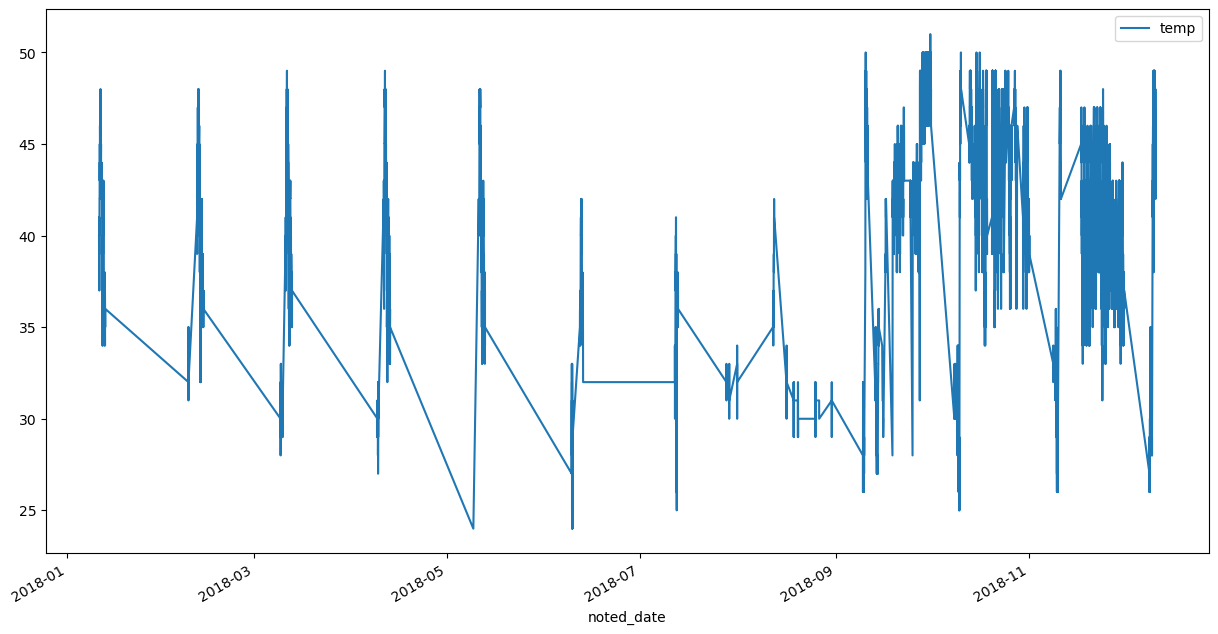

In [86]:
df_new.plot(figsize = (15,8))

## Since the temperature was recorded multiple times each day, I am calculating the mean for each day

In [100]:
# group the data by date and calculate the mean value for each group
grouped = df_new.groupby(pd.Grouper(freq='D',level=0)).mean()

# reset the index to make the 'datetime' column a regular column
grouped = grouped.reset_index()


In [107]:
grouped = grouped.set_index('noted_date')

## Filling the missing values using linear interpolation

In [119]:
grouped = grouped.interpolate()

# Checking the ETS

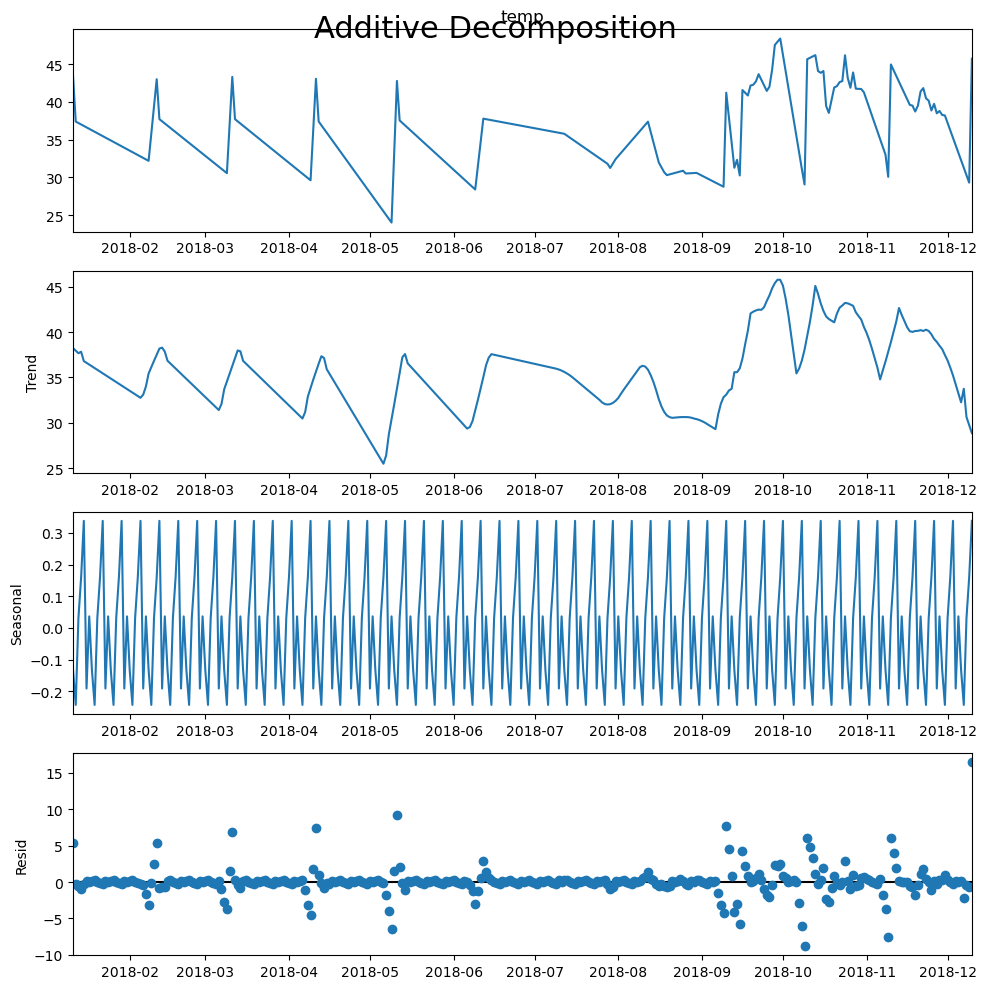

In [120]:

# Additive Decomposition
result_add = seasonal_decompose(grouped.temp, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()


## ADFuller test to see if the data is stationary

In [139]:
adfuller(grouped)

(-4.799403369602688,
 5.4529043103995246e-05,
 0,
 333,
 {'1%': -3.450141065277327,
  '5%': -2.870258846235788,
  '10%': -2.571415151457764},
 1434.1683966610785)

## since the p value is less than 0.05, the time series is stationary

## Finding the best model using autoarima

In [143]:
model = auto_arima(grouped, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1507.402, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1521.047, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1523.046, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1523.045, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1519.050, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1505.438, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1520.716, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1505.940, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1507.403, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1519.117, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1505.536, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1507.514, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1503.717, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1518.717, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [167]:
model = ARIMA(grouped, order=(1, 1, 2))
model = model.fit()


/home/shreya/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/shreya/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/shreya/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/shreya/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


# Checking the error

In [168]:
predictions = model.predict(start=pd.to_datetime('2018-01-11'), end=pd.to_datetime('2018-12-01'), dynamic=False)

In [170]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculating the RMSE and MAE
rmse = mean_squared_error(grouped['temp']['2018-01-11':'2018-12-01'], predictions, squared=False)
mae = mean_absolute_error(grouped['temp']['2018-01-11':'2018-12-01'], predictions)

print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 3.2214893548922037
MAE: 1.269521153508138


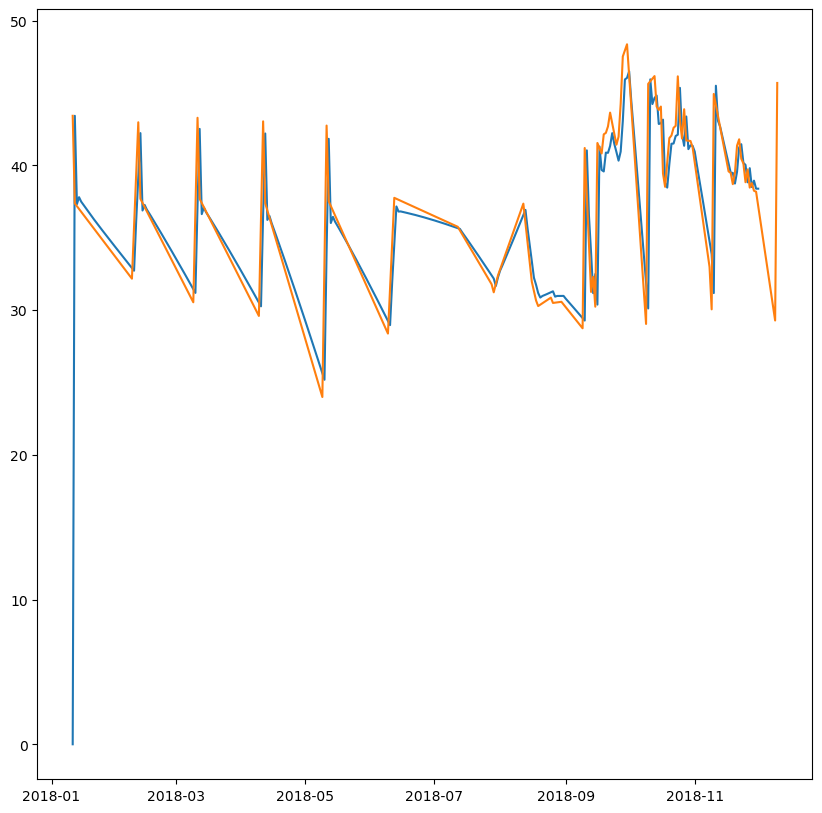

In [171]:
plt.plot(predictions)
plt.plot(grouped)

In [172]:
# The model is able to predict very closely the temperature for the training data

In [186]:
predictions = model.forecast(30)

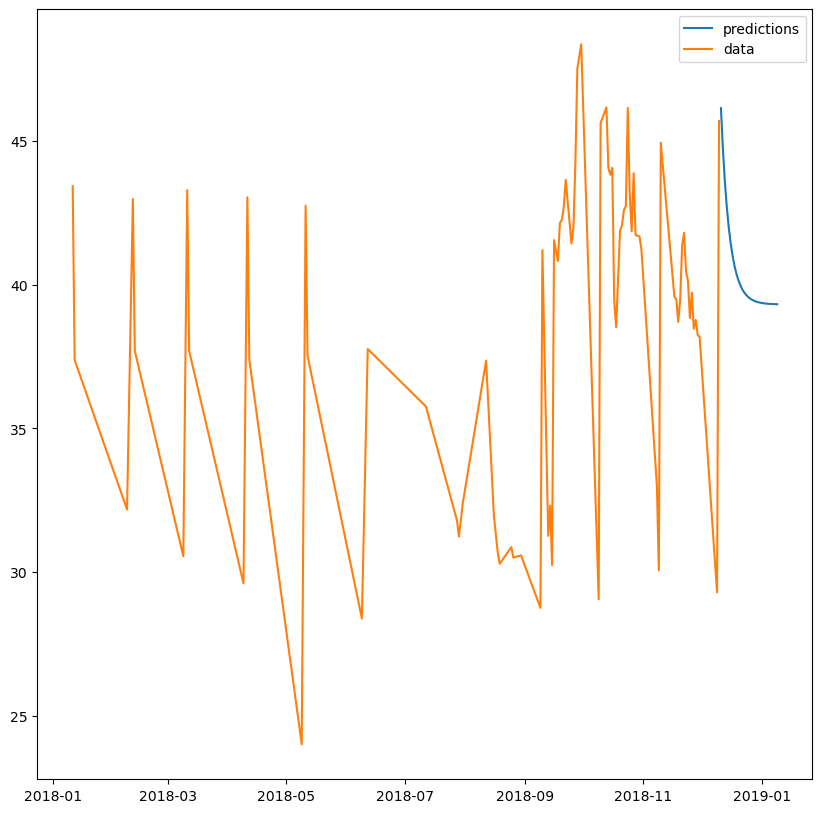

In [187]:
plt.plot(predictions,label='predictions')
plt.plot(grouped,label='data')
plt.legend()

## The model is able to make accurate predictions for around 30 days

This dataset contains the temperature readings from IOT devices installed outside and inside of an anonymous Room (say - admin room). The device was in the alpha testing phase. So, It was uninstalled or shut off several times during the entire reading period ( 28-07-2018 to 08-12-2018). This random interval recordings and few mis-readings ( outliers) makes it more challenging to perform analysis on this data. Since there are a lot of null values which were imputed using linear interpolation, the model is not able to perform well for more than 20 days